<a href="https://colab.research.google.com/github/dunnohow/LSTM_Autoencoder/blob/master/AE_LSTM_creditfraud.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<br>

#**Initialize**

In [1]:
!pip install -qq arff2pandas

In [2]:
!nvidia-smi

Tue Jul 21 00:12:20 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.51.05    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   40C    P0    28W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [3]:
!pip install -q -U watermark

In [4]:
!pip install -qq -U pandas

In [5]:
%reload_ext watermark
%watermark -v -p numpy,pandas,torch,arff2pandas

CPython 3.6.9
IPython 5.5.0

numpy 1.18.5
pandas 1.0.5
torch 1.5.1+cu101
arff2pandas 1.0.1


In [6]:
import torch

import copy
import numpy as np
import pandas as pd
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tqdm.notebook import tqdm

from torch import nn, optim
from torch.utils.data import DataLoader
import torch.nn.functional as F
from arff2pandas import a2p


%matplotlib inline
%config InlineBackend.figure_format='retina'

sns.set(style='whitegrid', palette='muted', font_scale=1.2)

HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#ADFF02", "#8F00FF"]

sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))

rcParams['figure.figsize'] = 12, 8

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [7]:
# 디바이스 설정
if torch.cuda.is_available():    
    device = torch.device("cuda")
    print('There are %d GPU(s) available.' % torch.cuda.device_count())
    print('We will use the GPU:', torch.cuda.get_device_name(0))
else:
    device = torch.device("cpu")
    print('No GPU available, using the CPU instead.')

There are 1 GPU(s) available.
We will use the GPU: Tesla P100-PCIE-16GB


<br>
<br>

#**Load Data**

In [9]:
import os
from google.colab import drive
drive.mount('/content/drive/')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive/


In [10]:
path = "/content/drive/My Drive/LSTM_prac/credit_fraud/"
os.listdir(path)

['creditcard.csv', 'LSTM_creditfraud.ipynb']

In [11]:
device = torch.device("cuda")

In [12]:
learning_rate = 0.01

In [13]:
train = pd.read_csv(path + 'creditcard.csv')
train.pop('Time')
train.shape

(284807, 30)

In [14]:
train.head()

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,-0.551600,-0.617801,-0.991390,-0.311169,1.468177,-0.470401,0.207971,0.025791,0.403993,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,1.612727,1.065235,0.489095,-0.143772,0.635558,0.463917,-0.114805,-0.183361,-0.145783,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,0.624501,0.066084,0.717293,-0.165946,2.345865,-2.890083,1.109969,-0.121359,-2.261857,0.524980,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,-0.226487,0.178228,0.507757,-0.287924,-0.631418,-1.059647,-0.684093,1.965775,-1.232622,-0.208038,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,-0.822843,0.538196,1.345852,-1.119670,0.175121,-0.451449,-0.237033,-0.038195,0.803487,0.408542,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [15]:
train.Class.value_counts()

0    284315
1       492
Name: Class, dtype: int64

In [16]:
train = train.iloc[:10000,:]

In [21]:
scaler = StandardScaler()

In [31]:
train_scaled = pd.DataFrame(scaler.fit_transform(train.iloc[:,:29]), columns=train.iloc[:,:29].columns)
train_scaled = pd.concat([train_scaled, train['Class']], axis=1, sort=False)
train_scaled.head()

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,-0.734715,-0.271185,1.406335,0.772992,-0.246790,0.251889,0.288932,0.129846,-0.379553,0.286963,-1.127616,0.428593,-1.519216,-0.816449,1.637899,-0.524532,-0.114887,0.052711,0.586897,0.379517,0.036862,0.682209,-0.158276,0.076705,0.096681,-0.528205,0.311650,-0.090025,0.469380,0
1,0.942243,-0.012077,-0.638247,0.127679,0.089964,-0.164826,-0.006603,0.119046,-0.915602,0.051234,0.724544,1.530357,-0.298694,-0.681367,0.784390,0.534769,-0.448904,-0.210631,-0.093239,-0.163728,-0.190186,-0.770144,0.275850,-0.607640,0.186909,0.031549,-0.035295,0.044357,-0.327088,0
2,-0.733760,-1.240077,0.747945,0.080235,-0.386177,1.275500,0.801160,0.248176,-2.005712,0.393821,-0.121147,0.876284,-0.110567,-0.699260,2.537608,-3.267895,0.818527,-0.132565,-2.711063,0.843219,0.328299,1.464779,1.932557,-1.195518,-0.968790,-0.439325,-0.148159,-0.235381,1.710945,0
3,-0.476083,-0.357147,0.765013,-0.782312,0.030510,0.852247,0.287085,0.351242,-1.895223,0.153678,-0.849395,0.949697,-0.283309,-0.797691,-0.514373,-1.192602,-1.038020,2.495341,-1.437782,-0.399259,-0.061625,0.250288,-0.321967,-2.013644,1.308492,-0.586513,0.139236,0.219893,0.327791,0
4,-0.602240,0.455470,0.554267,0.096371,-0.305015,-0.028446,0.616897,-0.163427,0.013432,0.892619,-1.359737,1.185341,0.407621,-1.468871,0.312401,-0.503045,-0.575390,-0.027853,1.081116,0.645855,0.046576,1.506929,-0.213596,0.201770,-0.684702,0.700385,0.520642,0.797187,0.037727,0


In [32]:
non_fraud = train_scaled[train_scaled.Class != 1].drop(labels = 'Class', axis = 1)
non_fraud = non_fraud.iloc[:10000,:]
non_fraud.shape

(9962, 29)

In [33]:
fraud = train_scaled[train_scaled.Class == 1].drop(labels = 'Class', axis = 1)
fraud.shape

(38, 29)

In [34]:
train_df, val_df = train_test_split(
    non_fraud,
    test_size=0.2,
    random_state=RANDOM_SEED
)

val_df, test_df = train_test_split(
    val_df,
    test_size=0.3,
    random_state=RANDOM_SEED
)

In [35]:
print(train_df.shape)
print(val_df.shape)
print(test_df.shape)

(7969, 29)
(1395, 29)
(598, 29)


In [36]:
def create_dataset(df):
    dataset = torch.tensor(df.values)
    dataset = dataset.unsqueeze(1)
    n_seq, seq_len, n_features = dataset.shape
    #n_seq, seq_len, n_features = torch.stack(dataset).shape
    return dataset, seq_len, n_features

In [37]:
train_dataset, seq_len, n_features = create_dataset(train_df)
val_dataset, _, _ = create_dataset(val_df)
test_normal_dataset, _, _ = create_dataset(test_df)
test_anomaly_dataset, _, _ = create_dataset(fraud)

In [38]:
print(train_dataset.shape)
print(val_dataset.shape)
print(test_normal_dataset.shape)
print(test_anomaly_dataset.shape)

torch.Size([7969, 1, 29])
torch.Size([1395, 1, 29])
torch.Size([598, 1, 29])
torch.Size([38, 1, 29])


In [39]:
train_loader = DataLoader(train_dataset, batch_size = 1, shuffle = False)
val_loader = DataLoader(val_dataset, batch_size = 1, shuffle = False)
test_loader = DataLoader(test_normal_dataset, batch_size = 1, shuffle = False)
anomaly_loader = DataLoader(test_anomaly_dataset, batch_size = 1, shuffle = False)

In [40]:
next(iter(train_loader)).shape

torch.Size([1, 1, 29])

<br>

#**Modeling**

In [41]:
class Encoder(nn.Module):

  def __init__(self, input_size, layer_node):
    super(Encoder, self).__init__()

    self.input_size = input_size
    self.layer_node = layer_node
    self.act = nn.GELU()

    for i in range(len(layer_node)):
        if i == 0:
            self.rnn1 = nn.LSTM(input_size=input_size, hidden_size=layer_node[i], batch_first = True)
        elif i != len(layer_node)-1:
            self.rnn2 = nn.LSTM(input_size=layer_node[i-1], hidden_size=layer_node[i], batch_first = True)
        else:
            self.rnn3 = nn.LSTM(input_size=layer_node[i-1], hidden_size=layer_node[i], batch_first = True)

  def forward(self, x):
    x, (_, _) = self.rnn1(x)
    x, (_, _) = self.rnn2(x)
    x, (_, _) = self.rnn3(x)

    return x

In [42]:
class Decoder(nn.Module):
    def __init__(self, input_size, layer_node):
        super(Decoder, self).__init__()
        self.input_size = input_size
        self.layer_node = layer_node
        self.act = nn.GELU()

        for j in range(len(layer_node)):
            if j == 0:
                self.rnn1 = nn.LSTM(input_size = layer_node[::-1][j], hidden_size = layer_node[::-1][j+1], batch_first = True)
            elif j != len(layer_node)-1:
                self.rnn2 = nn.LSTM(input_size = layer_node[::-1][j], hidden_size = layer_node[::-1][j+1], batch_first = True)
            else:
                self.rnn3 = nn.LSTM(input_size = layer_node[::-1][j], hidden_size = input_size, batch_first = True)

        self.output_layer = nn.Linear(input_size, input_size)

    def forward(self, x):

        x, (hidden_n, cell_n) = self.rnn1(x)
        x, (hidden_n, cell_n) = self.rnn2(x)
        x, (hidden_n, cell_n) = self.rnn3(x)
        x = self.output_layer(x)
        return x

In [43]:
class RecurrentAutoencoder(nn.Module):

  def __init__(self, input_size, layer_node):
    super(RecurrentAutoencoder, self).__init__()

    self.encoder = Encoder(input_size, layer_node).to(device)
    self.decoder = Decoder(input_size, layer_node).to(device)

  def forward(self, x):
    x = self.encoder(x)
    x = self.decoder(x)

    return x

In [44]:
layer_node = (20,10,5)
input_size = 29

In [45]:
model = RecurrentAutoencoder(input_size, layer_node)
model = model.cuda()

In [46]:
model

RecurrentAutoencoder(
  (encoder): Encoder(
    (act): GELU()
    (rnn1): LSTM(29, 20, batch_first=True)
    (rnn2): LSTM(20, 10, batch_first=True)
    (rnn3): LSTM(10, 5, batch_first=True)
  )
  (decoder): Decoder(
    (act): GELU()
    (rnn1): LSTM(5, 10, batch_first=True)
    (rnn2): LSTM(10, 20, batch_first=True)
    (rnn3): LSTM(20, 29, batch_first=True)
    (output_layer): Linear(in_features=29, out_features=29, bias=True)
  )
)

In [47]:
def train_model(model, train_dataset, val_dataset, n_epochs):
  optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
  criterion = nn.L1Loss(reduction='sum').cuda()
  history = dict(train=[], val=[])

  best_model_wts = copy.deepcopy(model.state_dict())
  best_loss = 10000.0

  for epoch in range(1, n_epochs + 1):
    model = model.train().double()

    train_losses = []
    for seq_true in train_dataset:
      optimizer.zero_grad()

      seq_true = seq_true.cuda()
      seq_pred = model(seq_true)

      loss = criterion(seq_pred, seq_true)

      loss.backward()
      optimizer.step()

      train_losses.append(loss.item())

    val_losses = []
    model = model.eval()
    with torch.no_grad():
      for seq_true in val_dataset:

        seq_true = seq_true.cuda()
        seq_pred = model(seq_true)

        loss = criterion(seq_pred, seq_true)
        val_losses.append(loss.item())

    train_loss = np.mean(train_losses)
    val_loss = np.mean(val_losses)

    history['train'].append(train_loss)
    history['val'].append(val_loss)

    if val_loss < best_loss:
      best_loss = val_loss
      best_model_wts = copy.deepcopy(model.state_dict())

    print(f'Epoch {epoch}: train loss {train_loss} val loss {val_loss}')

  model.load_state_dict(best_model_wts)
  return model.eval(), history

In [48]:
model, history = train_model(
  model,
  train_loader,
  val_loader,
  n_epochs=20
)

Epoch 1: train loss 16.931236759827307 val loss 16.483683215587217
Epoch 2: train loss 15.867979507066272 val loss 15.625429484046695
Epoch 3: train loss 15.263401699813171 val loss 15.297490099202099
Epoch 4: train loss 14.921690473146674 val loss 14.96043277691247
Epoch 5: train loss 14.683016236514488 val loss 14.75643122808382
Epoch 6: train loss 14.460756514358126 val loss 14.540988045167497
Epoch 7: train loss 14.321076461071767 val loss 14.454300642131624
Epoch 8: train loss 14.249560804933953 val loss 14.395473339913627
Epoch 9: train loss 14.181475848739105 val loss 14.360240955892811
Epoch 10: train loss 14.118691413614517 val loss 14.22772861013267
Epoch 11: train loss 14.045390038925209 val loss 14.229308269441642
Epoch 12: train loss 13.984698594877665 val loss 14.126905665430634
Epoch 13: train loss 13.942510171457029 val loss 14.095863945825746
Epoch 14: train loss 13.902449922960777 val loss 14.069418586588636
Epoch 15: train loss 13.850399939638718 val loss 14.00192445

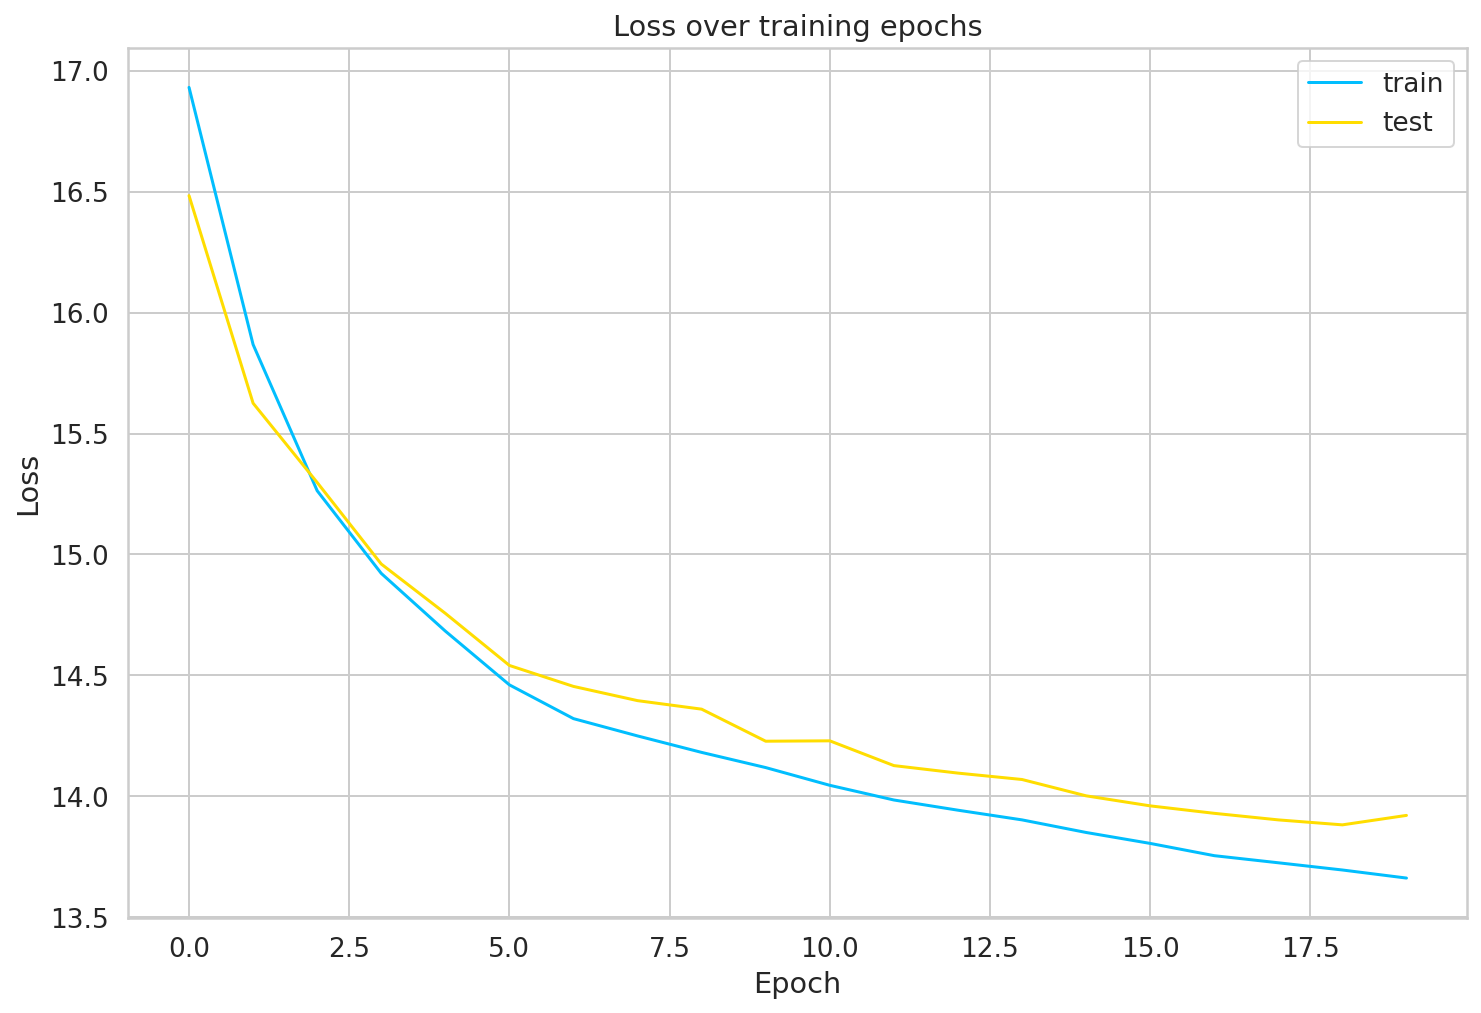

In [49]:
ax = plt.figure().gca()

ax.plot(history['train'])
ax.plot(history['val'])
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'test'])
plt.title('Loss over training epochs')
plt.show();

In [50]:
MODEL_PATH = 'model.pth'

torch.save(model, MODEL_PATH)

/usr/local/lib/python3.6/dist-packages/torch/serialization.py:402: UserWarning: Couldn't retrieve source code for container of type RecurrentAutoencoder. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:402: UserWarning: Couldn't retrieve source code for container of type Encoder. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:402: UserWarning: Couldn't retrieve source code for container of type Decoder. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


In [31]:
# !gdown --id 1jEYx5wGsb7Ix8cZAw3l5p5pOwHs3_I9A
# model = torch.load('model.pth')
# model = model.to(device)

In [51]:
def predict(model, dataset):
  predictions, losses = [], []
  criterion = nn.L1Loss(reduction='sum').to(device)
  with torch.no_grad():
    model = model.eval()
    for seq_true in dataset:
      seq_true = seq_true.to(device)
      seq_pred = model(seq_true)

      loss = criterion(seq_pred, seq_true)

      predictions.append(seq_pred.cpu().numpy().flatten())
      losses.append(loss.item())
  return predictions, losses

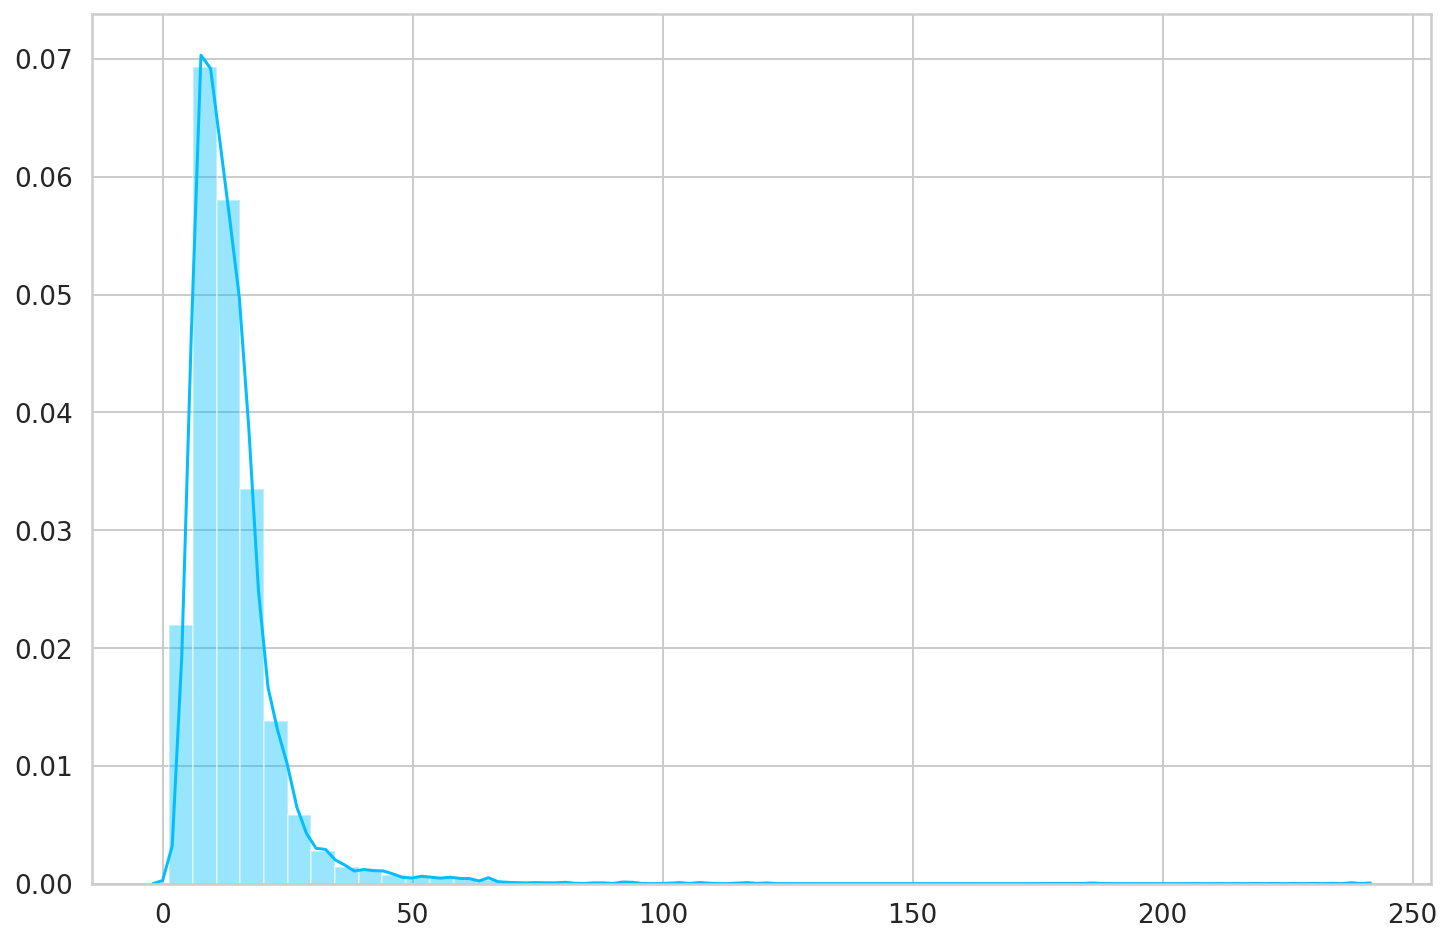

In [59]:
_, losses = predict(model, train_loader)

sns.distplot(losses, bins=50, kde=True);

In [53]:
THRESHOLD = 26

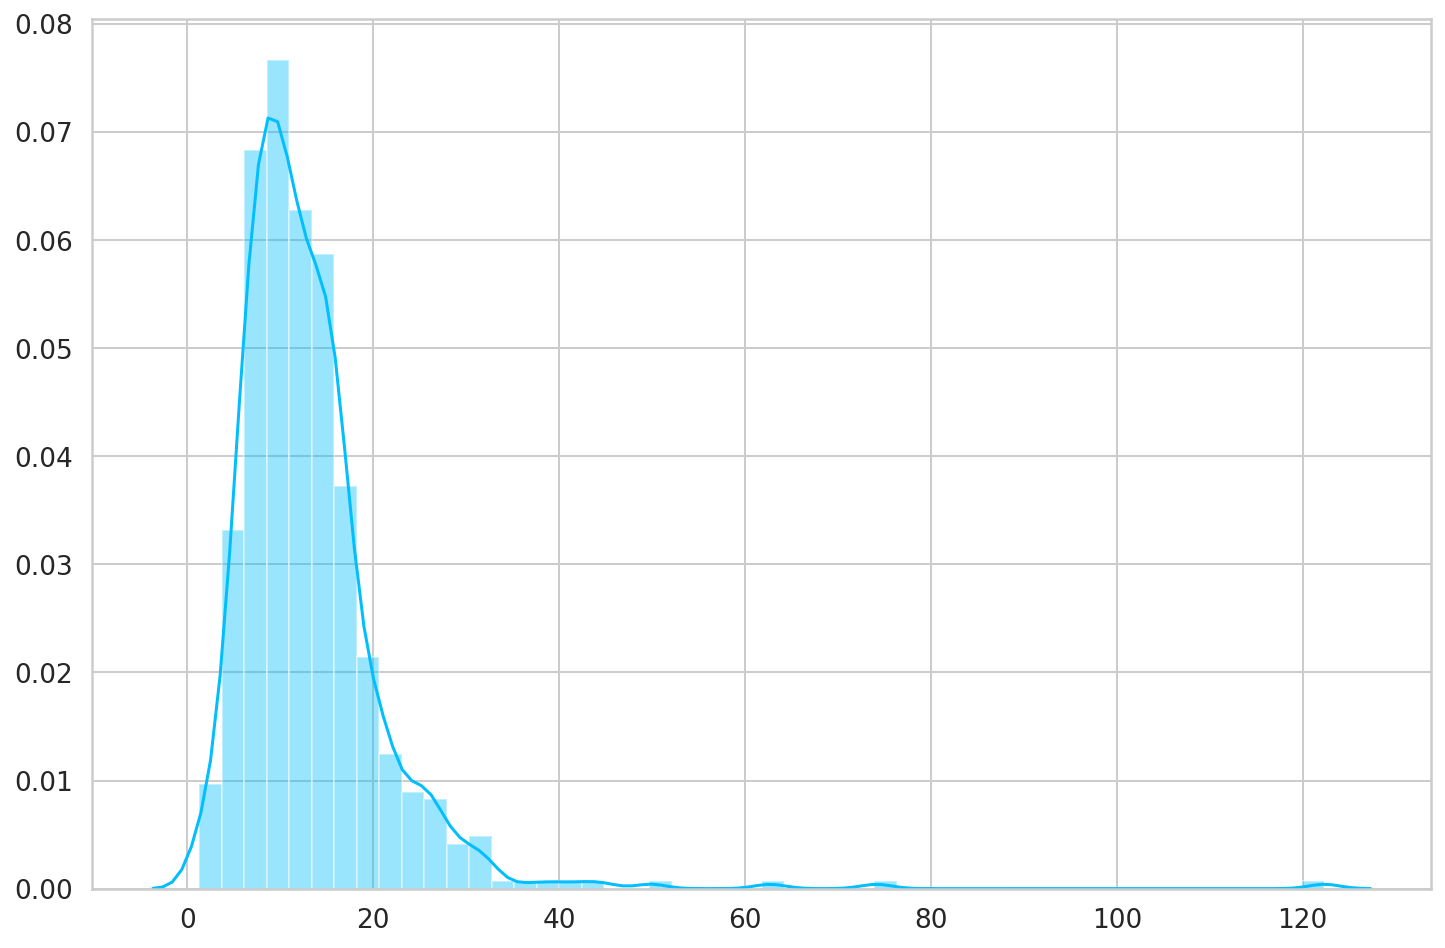

In [60]:
predictions, pred_losses = predict(model, test_loader)
sns.distplot(pred_losses, bins=50, kde=True);

In [61]:
correct = sum(l <= THRESHOLD for l in pred_losses)
print(f'Correct normal predictions: {correct}/{len(test_loader)}')

Correct normal predictions: 570/598


In [ ]:
anomaly_dataset = test_anomaly_dataset[:len(test_normal_dataset)]

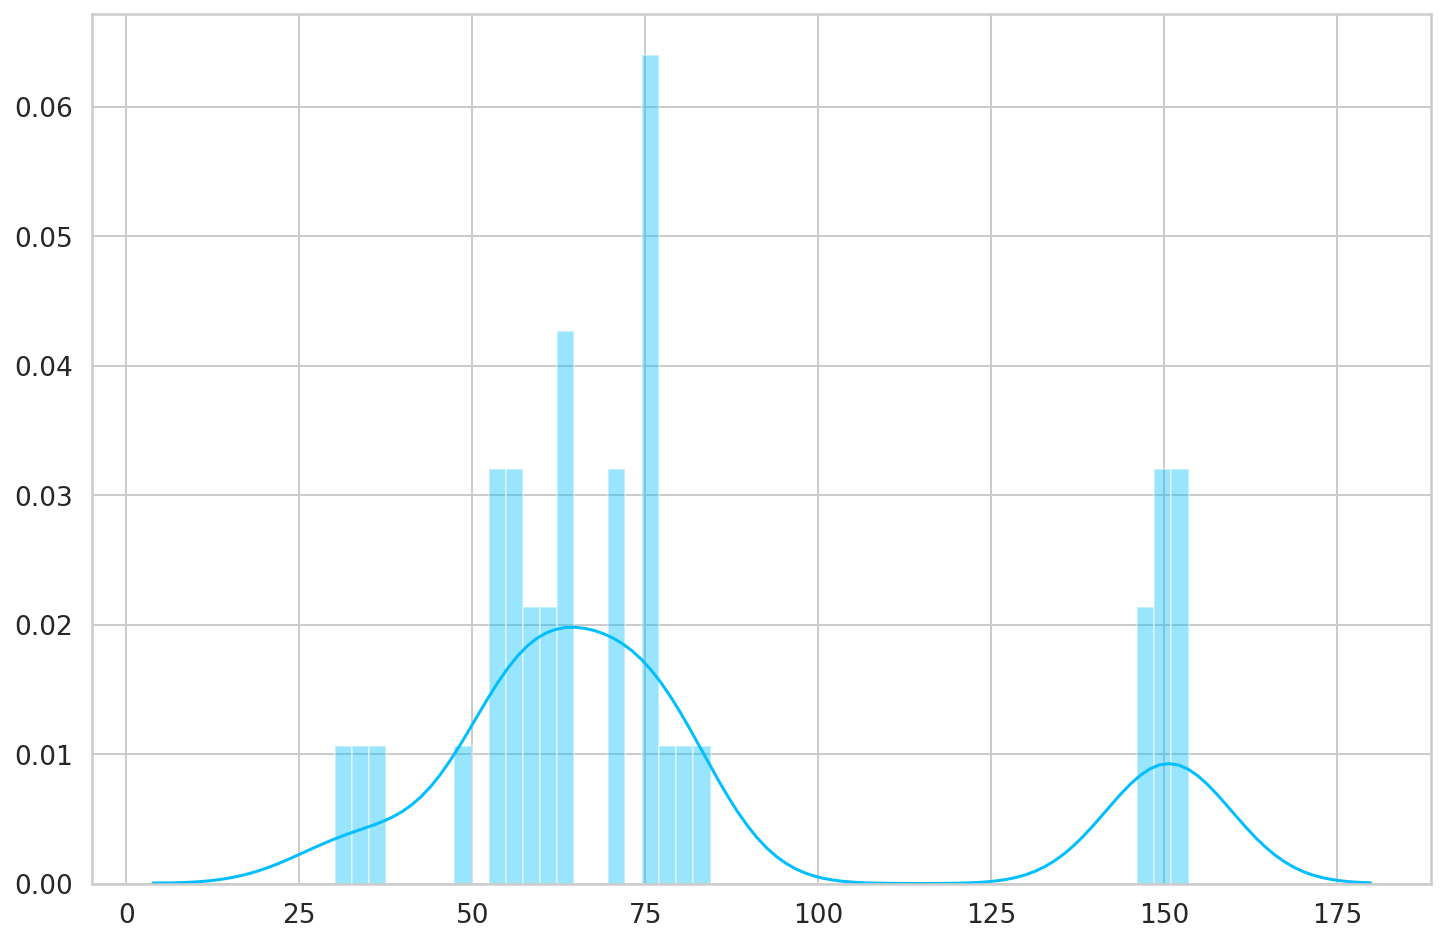

In [62]:
predictions, pred_losses = predict(model, anomaly_loader)
sns.distplot(pred_losses, bins=50, kde=True);

In [57]:
correct = sum(l > THRESHOLD for l in pred_losses)
print(f'Correct anomaly predictions: {correct}/{len(anomaly_loader)}')

Correct anomaly predictions: 38/38


In [58]:
def plot_prediction(data, model, title, ax):
  predictions, pred_losses = predict(model, [data])

  ax.plot(data, label='true')
  ax.plot(predictions[0], label='reconstructed')
  ax.set_title(f'{title} (loss: {np.around(pred_losses[0], 2)})')
  ax.legend()

In [ ]:
fig, axs = plt.subplots(
  nrows=2,
  ncols=6,
  sharey=True,
  sharex=True,
  figsize=(22, 8)
)

for i, data in enumerate(test_loader[:6]):
  plot_prediction(data, model, title='Normal', ax=axs[0, i])

for i, data in enumerate(anomaly_loader[:6]):
  plot_prediction(data, model, title='Anomaly', ax=axs[1, i])

fig.tight_layout();